<a href="https://colab.research.google.com/github/rajgaurang/myprofile/blob/master/Fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_real = pd.read_csv("/content/drive/MyDrive/news/BuzzFeed_real_news_content.csv")

In [ ]:
df_real.shape

(91, 12)

In [ ]:
df_fake=pd.read_csv('/content/drive/MyDrive/news/BuzzFeed_fake_news_content.csv')

In [ ]:
df_fake.shape

(91, 12)

In [ ]:
df=pd.concat([df_real,df_fake],axis=0)

In [ ]:
df.shape

(182, 12)

In [ ]:
df['news_type']=df['id'].apply(lambda x: x.split('_')[0])

In [ ]:
df.head(2)

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_type
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",Real
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",Real


In [ ]:
df.drop(['id','url', 'top_img','authors','publish_date','canonical_link','meta_data'],axis=1, inplace=True)

In [ ]:
df.isnull().sum()

title          0
text           0
source         8
movies       157
images        10
news_type      0
dtype: int64

In [ ]:
(df.isnull().sum())/(df.shape[0])*100

title         0.000000
text          0.000000
source        4.395604
movies       86.263736
images        5.494505
news_type     0.000000
dtype: float64

In [ ]:
df['contain_movies']=df['movies'].apply(lambda x: 0 if str(x)=='nan' else 1)

In [ ]:
df['contain_images']=df['images'].apply(lambda x: 0 if str(x)=='nan' else 1)

In [ ]:
df.drop(['movies','images'],axis=1,inplace=True)

In [ ]:
df.head(2)

,title,text,source,news_type,contain_movies,contain_images
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1


In [ ]:
real_order=df[df['news_type']=='Real']['source'].value_counts().sort_values(ascending=False).index

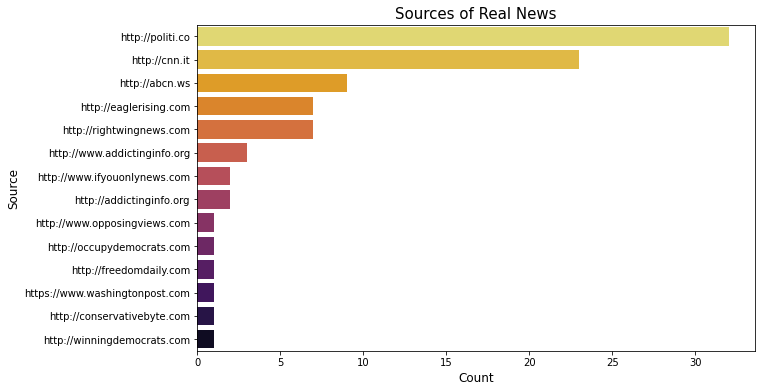

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=df[df['news_type']=='Real'],order=real_order,palette='inferno_r')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Real News',fontsize=15)
plt.show()

In [ ]:
fake_order=df[df['news_type']=='Fake']['source'].value_counts().sort_values(ascending=False).index

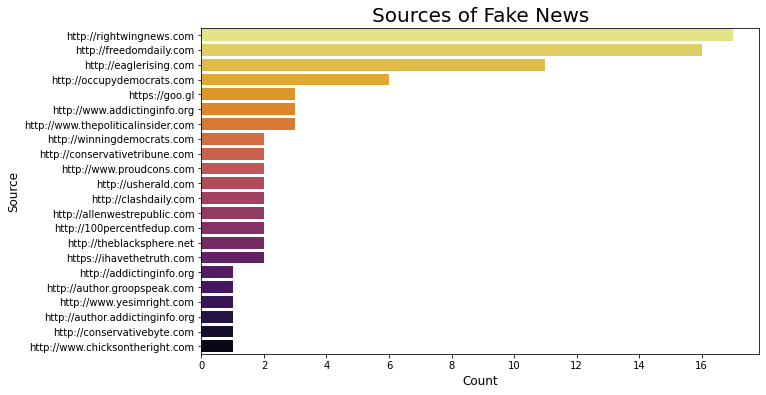

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(y='source',data=df[df['news_type']=='Fake'],order=fake_order,palette='inferno_r')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=20)
plt.show()


In [ ]:
new=[]
for x in df[df['news_type']=='Fake']['source'].unique():
    if x in df[df['news_type']=='Real']['source'].unique():
        new.append(x)
print(new)

['http://www.addictinginfo.org', 'http://eaglerising.com', 'http://conservativebyte.com', 'http://winningdemocrats.com', 'http://freedomdaily.com', 'http://occupydemocrats.com', 'http://rightwingnews.com', 'http://addictinginfo.org']


In [ ]:
df['common']=df['source'].apply(lambda x: x if x in new else 0)

In [ ]:
df1=df[df['common']!=0]

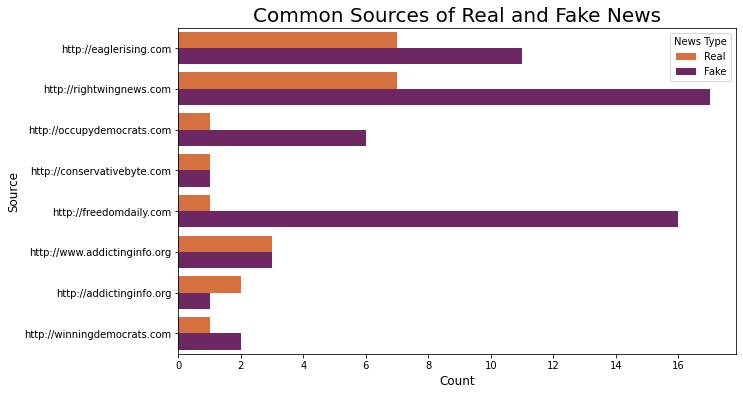

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(y='common',data=df1,hue='news_type',palette='inferno_r')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Common Sources of Real and Fake News',fontsize=20)
plt.show()

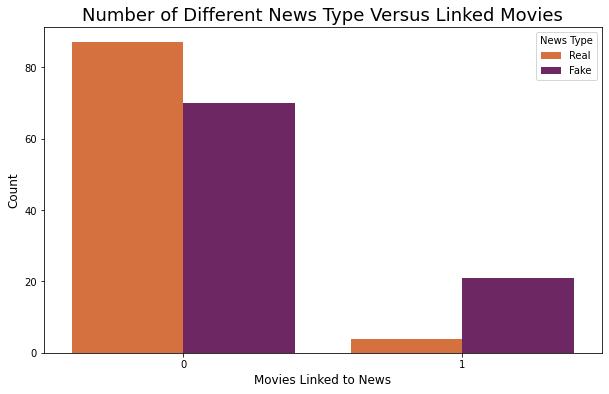

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_movies', data=df, hue='news_type', palette='inferno_r')
plt.xlabel('Movies Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Movies',fontsize=18)
plt.show()

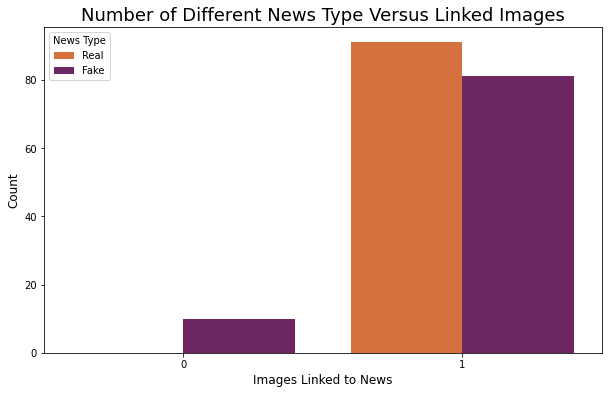

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='contain_images', data=df, hue='news_type', palette='inferno_r')
plt.xlabel('Images Linked to News',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='upper left', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Images',fontsize=18)
plt.show()

In [ ]:
ps=PorterStemmer()
wst= WhitespaceTokenizer() 

##### 1. Converting text to lower case
def lower_func (x):
    return x.lower()


##### 2. Removing Numbers from the text corpus
def remove_number_func (x): 
    new=""
    for a in x:
        if a.isdigit()==False:
            new=new+a
    return new


##### 3. Removing punctuation 
def remove_punc_func(x):
    new=''
    for a in x:
        if a not in string.punctuation:
            new=new+a
    return new

##### 4. Removing special characters
def remove_spec_char_func(x):
    new=''
    for a in x:
        if (a.isalnum()==True) or (a==' '):
            new=new+a
    return(new)

##### 5. Removing english stopwords
def remove_stopwords(x):
    new=[]
    for a in x.split():
        if a not in stopwords.words('english'):
            new.append(a)
    return " ".join(new)

##### 6. Stemming words to root words
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

##### 7. Removing extra whitespaces 
def remove_whitespace_func(x):
    return(wst.tokenize(x))

def compose(f, g):
    return lambda x: f(g(x))

final=compose(compose(compose(compose(compose(compose(remove_whitespace_func,stem_func),remove_stopwords),remove_spec_char_func),remove_punc_func),remove_number_func),lower_func)

In [ ]:
df_fake=df[df['news_type']=='Fake']

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
cv1 = CountVectorizer(analyzer=final)
cv1.fit(df_fake['title'])
bow1=cv1.transform(df_fake['title'])

In [ ]:
pd.DataFrame(bow1.todense()).shape

(91, 459)

In [ ]:
new1=[]
for x in range(0,459):
    new1.append(cv1.get_feature_names()[x])

In [ ]:
matrix1=pd.DataFrame(bow1.todense(),columns=new1)

In [ ]:
sm1=[]
for x in new1:
    sm1.append(matrix1[x].sum())

In [ ]:
trans1=matrix1.transpose()

In [ ]:
trans1['sum']=sm1

In [ ]:
top1=trans1.sort_values(by='sum', ascending=False).head(20)

In [ ]:
df_real=df[df['news_type']=='Real']

In [ ]:
cv2 = CountVectorizer(analyzer=final)
cv2.fit(df_real['title'])
bow2=cv2.transform(df_real['title'])

In [ ]:
pd.DataFrame(bow2.todense()).shape

(91, 436)

In [ ]:
new2=[]
for x in range(0,436):
    new2.append(cv2.get_feature_names()[x])

In [ ]:
matrix2=pd.DataFrame(bow2.todense(),columns=new2)

In [ ]:
sm2=[]
for x in new2:
    sm2.append(matrix2[x].sum())

In [ ]:
trans2=matrix2.transpose()

In [ ]:
trans2['sum']=sm2

In [ ]:
top2=trans2.sort_values(by='sum', ascending=False).head(20)

In [ ]:
top1.drop(list(range(0,91)),axis=1,inplace=True)

In [ ]:
top1['type']=['Fake']*20
top2.drop(list(range(0,91)),axis=1,inplace=True)
top2['type']=['Real']*20
conc1=pd.concat([top1,top2])

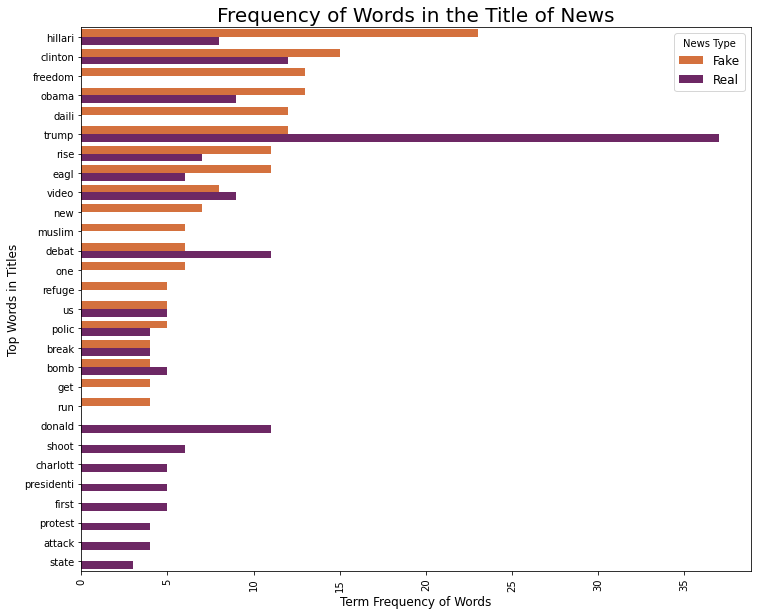

In [ ]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc1.index,x='sum',data=conc1,hue='type',palette='inferno_r')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Titles',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Title of News',fontsize=20)
plt.show()

In [ ]:
cv3 = CountVectorizer(analyzer=final)
cv3.fit(df_fake['text'])
bow3=cv3.transform(df_fake['text'])

In [ ]:
pd.DataFrame(bow3.todense()).shape

(91, 4958)

In [ ]:
new3=[]
for x in range(0,4958):
    new3.append(cv3.get_feature_names()[x])
matrix3=pd.DataFrame(bow3.todense(),columns=new3)
sm3=[]
for x in new3:
    sm3.append(matrix3[x].sum())

In [ ]:
trans3=matrix3.transpose()
trans3['sum']=sm3
top3=trans3.sort_values(by='sum', ascending=False).head(30)

In [ ]:
cv4 = CountVectorizer(analyzer=final)
cv4.fit(df_real['text'])
bow4=cv4.transform(df_real['text'])
pd.DataFrame(bow4.todense()).shape

(91, 6529)

In [ ]:
new4=[]
for x in range(0,6529):
    new4.append(cv4.get_feature_names()[x])

In [ ]:
matrix4=pd.DataFrame(bow4.todense(),columns=new4)

In [ ]:
sm4=[]
for x in new4:
    sm4.append(matrix4[x].sum())

In [ ]:
trans4=matrix4.transpose()

In [ ]:
trans4['sum']=sm4

In [ ]:
top4=trans4.sort_values(by='sum', ascending=False).head(30)

In [ ]:
top3.drop(list(range(0,91)),axis=1,inplace=True)

In [ ]:
top3['type']=['Fake']*30

In [ ]:
top4.drop(list(range(0,91)),axis=1,inplace=True)

In [ ]:
top4['type']=['Real']*30

In [ ]:
conc2=pd.concat([top3,top4])

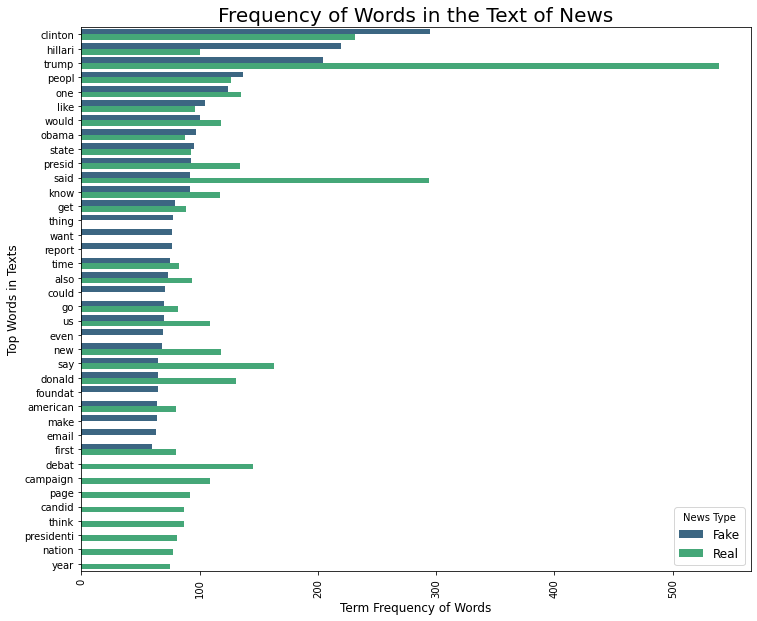

In [ ]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc2.index,x='sum',data=conc2,hue='type',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Texts',fontsize=12)
plt.legend(title='News Type',fontsize=12,loc='lower right')
plt.title('Frequency of Words in the Text of News',fontsize=20)
plt.show()

In [ ]:
df['title_length']=df['title'].apply(lambda x: len(x))

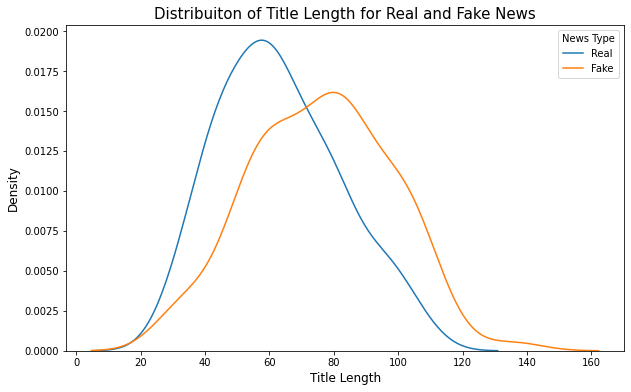

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['news_type']=='Real']['title_length'])
sns.kdeplot(df[df['news_type']=='Fake']['title_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribuiton of Title Length for Real and Fake News',fontsize=15)
plt.show()

In [ ]:
X1=df['text']
y1=df['news_type']

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [ ]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [ ]:
predictions1=pp.predict(X1_test)

In [ ]:
print(confusion_matrix(y1_test, predictions1))
print('\n')
print(classification_report(y1_test, predictions1))

[[22  4]
 [ 7 22]]


              precision    recall  f1-score   support

        Fake       0.76      0.85      0.80        26
        Real       0.85      0.76      0.80        29

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [ ]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [ ]:
predictions2=pp.predict(X1_test)

In [ ]:
print(confusion_matrix(y1_test, predictions2))
print('\n')
print(classification_report(y1_test, predictions2))

[[18  8]
 [ 5 24]]


              precision    recall  f1-score   support

        Fake       0.78      0.69      0.73        26
        Real       0.75      0.83      0.79        29

    accuracy                           0.76        55
   macro avg       0.77      0.76      0.76        55
weighted avg       0.77      0.76      0.76        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [ ]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=Fal

In [ ]:
predictions3=pp.predict(X1_test)

In [ ]:
print(confusion_matrix(y1_test, predictions3))
print('\n')
print(classification_report(y1_test, predictions3))

[[22  4]
 [13 16]]


              precision    recall  f1-score   support

        Fake       0.63      0.85      0.72        26
        Real       0.80      0.55      0.65        29

    accuracy                           0.69        55
   macro avg       0.71      0.70      0.69        55
weighted avg       0.72      0.69      0.69        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [ ]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predictions4=pp.predict(X1_test)


In [ ]:
print(confusion_matrix(y1_test, predictions4))
print('\n')
print(classification_report(y1_test, predictions4))

[[25  1]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.60      0.96      0.74        26
        Real       0.92      0.41      0.57        29

    accuracy                           0.67        55
   macro avg       0.76      0.69      0.65        55
weighted avg       0.77      0.67      0.65        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [ ]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
       

In [ ]:
predictions5=pp.predict(X1_test)

In [ ]:
print(confusion_matrix(y1_test, predictions5))
print('\n')
print(classification_report(y1_test, predictions5))

[[21  5]
 [ 8 21]]


              precision    recall  f1-score   support

        Fake       0.72      0.81      0.76        26
        Real       0.81      0.72      0.76        29

    accuracy                           0.76        55
   macro avg       0.77      0.77      0.76        55
weighted avg       0.77      0.76      0.76        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [ ]:
pp.fit(X1_train,y1_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [ ]:
predictions6=pp.predict(X1_test)

In [ ]:
print(confusion_matrix(y1_test, predictions6))
print('\n')
print(classification_report(y1_test, predictions6))

[[23  3]
 [ 2 27]]


              precision    recall  f1-score   support

        Fake       0.92      0.88      0.90        26
        Real       0.90      0.93      0.92        29

    accuracy                           0.91        55
   macro avg       0.91      0.91      0.91        55
weighted avg       0.91      0.91      0.91        55



In [ ]:
X2=df['title']
y2=df['news_type']

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [ ]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [ ]:
predictions7=pp.predict(X2_test)

In [ ]:
print(confusion_matrix(y2_test, predictions7))
print('\n')
print(classification_report(y2_test, predictions7))

[[20  6]
 [12 17]]


              precision    recall  f1-score   support

        Fake       0.62      0.77      0.69        26
        Real       0.74      0.59      0.65        29

    accuracy                           0.67        55
   macro avg       0.68      0.68      0.67        55
weighted avg       0.69      0.67      0.67        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [ ]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [ ]:
predictions8=pp.predict(X2_test)

In [ ]:
print(confusion_matrix(y2_test, predictions8))
print('\n')
print(classification_report(y2_test, predictions8))

[[15 11]
 [10 19]]


              precision    recall  f1-score   support

        Fake       0.60      0.58      0.59        26
        Real       0.63      0.66      0.64        29

    accuracy                           0.62        55
   macro avg       0.62      0.62      0.62        55
weighted avg       0.62      0.62      0.62        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [ ]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=Fal

In [ ]:
predictions9=pp.predict(X2_test)

In [ ]:
print(confusion_matrix(y2_test, predictions9))
print('\n')
print(classification_report(y2_test, predictions9))

[[21  5]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.55      0.81      0.66        26
        Real       0.71      0.41      0.52        29

    accuracy                           0.60        55
   macro avg       0.63      0.61      0.59        55
weighted avg       0.63      0.60      0.59        55



In [ ]:
print(confusion_matrix(y2_test, predictions9))
print('\n')
print(classification_report(y2_test, predictions9))

[[21  5]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.55      0.81      0.66        26
        Real       0.71      0.41      0.52        29

    accuracy                           0.60        55
   macro avg       0.63      0.61      0.59        55
weighted avg       0.63      0.60      0.59        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [ ]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predictions10=pp.predict(X2_test)

In [ ]:
print(confusion_matrix(y2_test, predictions10))
print('\n')
print(classification_report(y2_test, predictions10))

[[22  4]
 [19 10]]


              precision    recall  f1-score   support

        Fake       0.54      0.85      0.66        26
        Real       0.71      0.34      0.47        29

    accuracy                           0.58        55
   macro avg       0.63      0.60      0.56        55
weighted avg       0.63      0.58      0.56        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [ ]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
       

In [ ]:
predictions11=pp.predict(X2_test)

In [ ]:
print(confusion_matrix(y2_test, predictions11))
print('\n')
print(classification_report(y2_test, predictions11))

[[21  5]
 [15 14]]


              precision    recall  f1-score   support

        Fake       0.58      0.81      0.68        26
        Real       0.74      0.48      0.58        29

    accuracy                           0.64        55
   macro avg       0.66      0.65      0.63        55
weighted avg       0.66      0.64      0.63        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [ ]:
pp.fit(X2_train,y2_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [ ]:
predictions12=pp.predict(X2_test)

In [ ]:
print(confusion_matrix(y2_test, predictions12))
print('\n')
print(classification_report(y2_test, predictions12))

[[19  7]
 [17 12]]


              precision    recall  f1-score   support

        Fake       0.53      0.73      0.61        26
        Real       0.63      0.41      0.50        29

    accuracy                           0.56        55
   macro avg       0.58      0.57      0.56        55
weighted avg       0.58      0.56      0.55        55



In [ ]:
df['title_text']=df['title']+': ' +df['text']

In [ ]:
X3=df['title_text']
y3=df['news_type']

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [ ]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [ ]:
predictions13=pp.predict(X3_test)

In [ ]:
print(confusion_matrix(y3_test, predictions13))
print('\n')
print(classification_report(y3_test, predictions13))

[[24  2]
 [ 8 21]]


              precision    recall  f1-score   support

        Fake       0.75      0.92      0.83        26
        Real       0.91      0.72      0.81        29

    accuracy                           0.82        55
   macro avg       0.83      0.82      0.82        55
weighted avg       0.84      0.82      0.82        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
    ])

In [ ]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [ ]:
predictions14=pp.predict(X3_test)

In [ ]:
print(confusion_matrix(y3_test, predictions14))
print('\n')
print(classification_report(y3_test, predictions14))

[[19  7]
 [ 7 22]]


              precision    recall  f1-score   support

        Fake       0.73      0.73      0.73        26
        Real       0.76      0.76      0.76        29

    accuracy                           0.75        55
   macro avg       0.74      0.74      0.74        55
weighted avg       0.75      0.75      0.75        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])

In [ ]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=Fal

In [ ]:
predictions15=pp.predict(X3_test)

In [ ]:
print(confusion_matrix(y3_test, predictions15))
print('\n')
print(classification_report(y3_test, predictions15))

[[22  4]
 [15 14]]


              precision    recall  f1-score   support

        Fake       0.59      0.85      0.70        26
        Real       0.78      0.48      0.60        29

    accuracy                           0.65        55
   macro avg       0.69      0.66      0.65        55
weighted avg       0.69      0.65      0.64        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
    ])


In [ ]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predictions16=pp.predict(X3_test)

In [ ]:
print(confusion_matrix(y3_test, predictions16))
print('\n')
print(classification_report(y3_test, predictions16))

[[25  1]
 [19 10]]


              precision    recall  f1-score   support

        Fake       0.57      0.96      0.71        26
        Real       0.91      0.34      0.50        29

    accuracy                           0.64        55
   macro avg       0.74      0.65      0.61        55
weighted avg       0.75      0.64      0.60        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer(analyzer=final)),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [ ]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x7f811c7ac050>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
       

In [ ]:
predictions17=pp.predict(X3_test)

In [ ]:
print(confusion_matrix(y3_test, predictions17))
print('\n')
print(classification_report(y3_test, predictions17))

[[20  6]
 [ 9 20]]


              precision    recall  f1-score   support

        Fake       0.69      0.77      0.73        26
        Real       0.77      0.69      0.73        29

    accuracy                           0.73        55
   macro avg       0.73      0.73      0.73        55
weighted avg       0.73      0.73      0.73        55



In [ ]:
pp=Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',PassiveAggressiveClassifier())
    ])

In [ ]:
pp.fit(X3_train,y3_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [ ]:
predictions18=pp.predict(X3_test)

In [ ]:
print(confusion_matrix(y3_test, predictions18))
print('\n')
print(classification_report(y3_test, predictions18))

[[23  3]
 [ 4 25]]


              precision    recall  f1-score   support

        Fake       0.85      0.88      0.87        26
        Real       0.89      0.86      0.88        29

    accuracy                           0.87        55
   macro avg       0.87      0.87      0.87        55
weighted avg       0.87      0.87      0.87        55



In [ ]:
print('Text_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions1)))
print('Text_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions2)))
print('Text_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions3)))
print('Text_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions4)))
print('Text_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions5)))
print('Text_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y1_test,predictions6)))
print('\n')
print('Title_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions7)))
print('Title_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions8)))
print('Title_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions9)))
print('Title_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions10)))
print('Title_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions11)))
print('Title_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y2_test,predictions12)))
print('\n')
print('Text&Title_Random Forest Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions13)))
print('Text&Title_Random Forest Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions14)))
print('Text&Title_Naive Bayes Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions15)))
print('Text&Title_Naive Bayes Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions16)))
print('Text&Title_Passive Aggressive Classifier_With Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions17)))
print('Text&Title_Passive Aggressive Classifier_Without Text Preprocessing: ', round(100*accuracy_score(y3_test,predictions18)))

Text_Random Forest Classifier_With Text Preprocessing:  80
Text_Random Forest Classifier_Without Text Preprocessing:  76
Text_Naive Bayes Classifier_With Text Preprocessing:  69
Text_Naive Bayes Classifier_Without Text Preprocessing:  67
Text_Passive Aggressive Classifier_With Text Preprocessing:  76
Text_Passive Aggressive Classifier_Without Text Preprocessing:  91


Title_Random Forest Classifier_With Text Preprocessing:  67
Title_Random Forest Classifier_Without Text Preprocessing:  62
Title_Naive Bayes Classifier_With Text Preprocessing:  60
Title_Naive Bayes Classifier_Without Text Preprocessing:  58
Title_Passive Aggressive Classifier_With Text Preprocessing:  64
Title_Passive Aggressive Classifier_Without Text Preprocessing:  56


Text&Title_Random Forest Classifier_With Text Preprocessing:  82
Text&Title_Random Forest Classifier_Without Text Preprocessing:  75
Text&Title_Naive Bayes Classifier_With Text Preprocessing:  65
Text&Title_Naive Bayes Classifier_Without Text Preproces